# Pacific map with Effort area outlined and our paper area overlaid to show overlap

Author: Johanna L K Wren

Email:  johanna.wren@noaa.gov

Date:   November 26, 2025


## Description
This map is for the climate variability publications with Phoebe and Ryan. This is figure 1, showing the total area of effort with the area we extracted climate variables from overlaid. Mollewide projection. 


In [ ]:
import pygmt
import geopandas as gpd
import pandas as pd
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from concave_hull import concave_hull, concave_hull_indexes
from smoothify import smoothify
from shapely import Polygon

# For the mask
import numpy as np
from geocube.api.core import make_geocube

## Read in fisheries data

These data show the area over which the Hawaii Deep-Set longine fishery operates between 1995-2024.  

In [276]:
# Load data
df = pd.read_csv('~/Documents/ClimateVariability/ENSO_LonglineFishery/FisheryData/Longline data/DeepSets.csv')
df = df.drop(df[df.BH_LON==0].index) # Remove the zero lon locations
df.BH_LON = (df.BH_LON*-1)+360

Make the mask from individual point location fisheries data to process the effort for confidentiality. pyGMT is great at gridding point data, but while it can do counts it cannot do unique counts, so I have to use python to do this. The easiest way I have found is using geocube

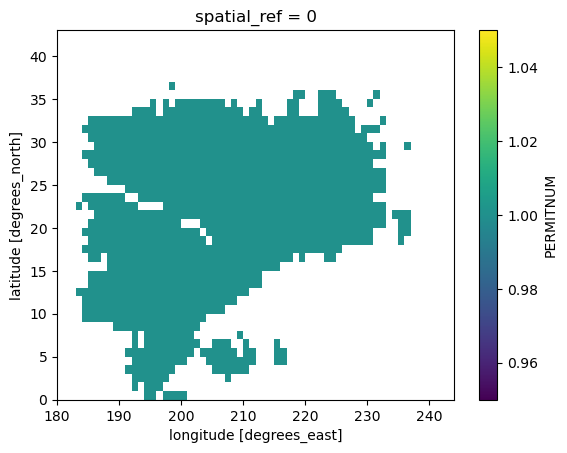

In [298]:
# Make a geo dataframe out of the fisheries data
geometry = [Point(xy) for xy in zip(df['BH_LON'], df['BH_LAT'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Define resolution of the grid
res = 1.0 # 1 degree

# Create a grid-based ID for each point
gdf['x_grid'] = (gdf.geometry.x / res).astype(int) * res
gdf['y_grid'] = (gdf.geometry.y / res).astype(int) * res

# Group by grid cells and count unique values
agg_gdf = gdf.groupby(['x_grid', 'y_grid'])['PERMITNUM'].nunique().reset_index()

# Re-convert back to a GeoDataFrame (for make_geocube)
agg_gdf = gpd.GeoDataFrame(
    agg_gdf, 
    geometry=gpd.points_from_xy(agg_gdf.x_grid, agg_gdf.y_grid), 
    crs=gdf.crs
)

# Create the geocube
cube = make_geocube(
    vector_data=agg_gdf,
    measurements=['PERMITNUM'], # This now holds the unique count
    resolution=(-res, res) # Fill empty cells with 0 unique values
)

# Replace all values below 3 with NA and all other values with 1
cubemask = cube.where(cube >= 3)
cubemask = cubemask.where(cubemask.isnull(), other=1)
# save only the permitnum as dataarray
mask = cubemask.PERMITNUM
# rename x and y to lat and lon
mask = mask.rename({'x': 'lon', 'y': 'lat'})

# Plot to see results
mask.plot()

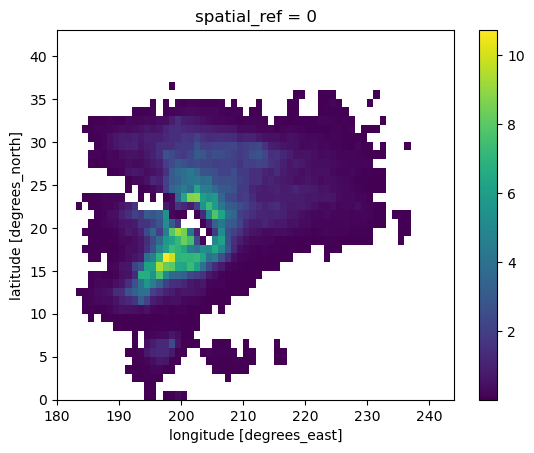

In [ ]:
# Grid the effort data
data=df[['BH_LON', 'BH_LAT', 'HOOKSSET']]
region=[cubemask.x.min().item(), cubemask.x.max().item(), cubemask.y.min().item(), cubemask.y.max().item()]
spacing='1d'

# pyGMTs blockmean is really handy to make grids
myDat = pygmt.blockmean(data=data, region=region, spacing=spacing, summary='s')
grd=pygmt.xyz2grd(data=myDat, region=region, spacing=spacing)

# Apply the confidentiality mask to the data and reduce effort to per million hooks
effort = (grd/1000000)*mask

# Plot to check results
effort.plot()

## Make the map

pyGMT works quite similar to GMT, but instead of the letters you use words. There is [good documentation](https://www.pygmt.org/latest/index.html) that shows the 'key' so you can easily convert a GMT script to pyGMT without too much effort. PyGMT is pretty modular just like GMT and works pretty much the same way. I found it pretty easy to figure out the syntax in pyGMT

Here we are making a simple map with coastlines and a box showing the study area and the above shape showing the deep-set longline fishery footprint. I like to define as much as possible outside of the plotting, so the region, the projection, etc. 


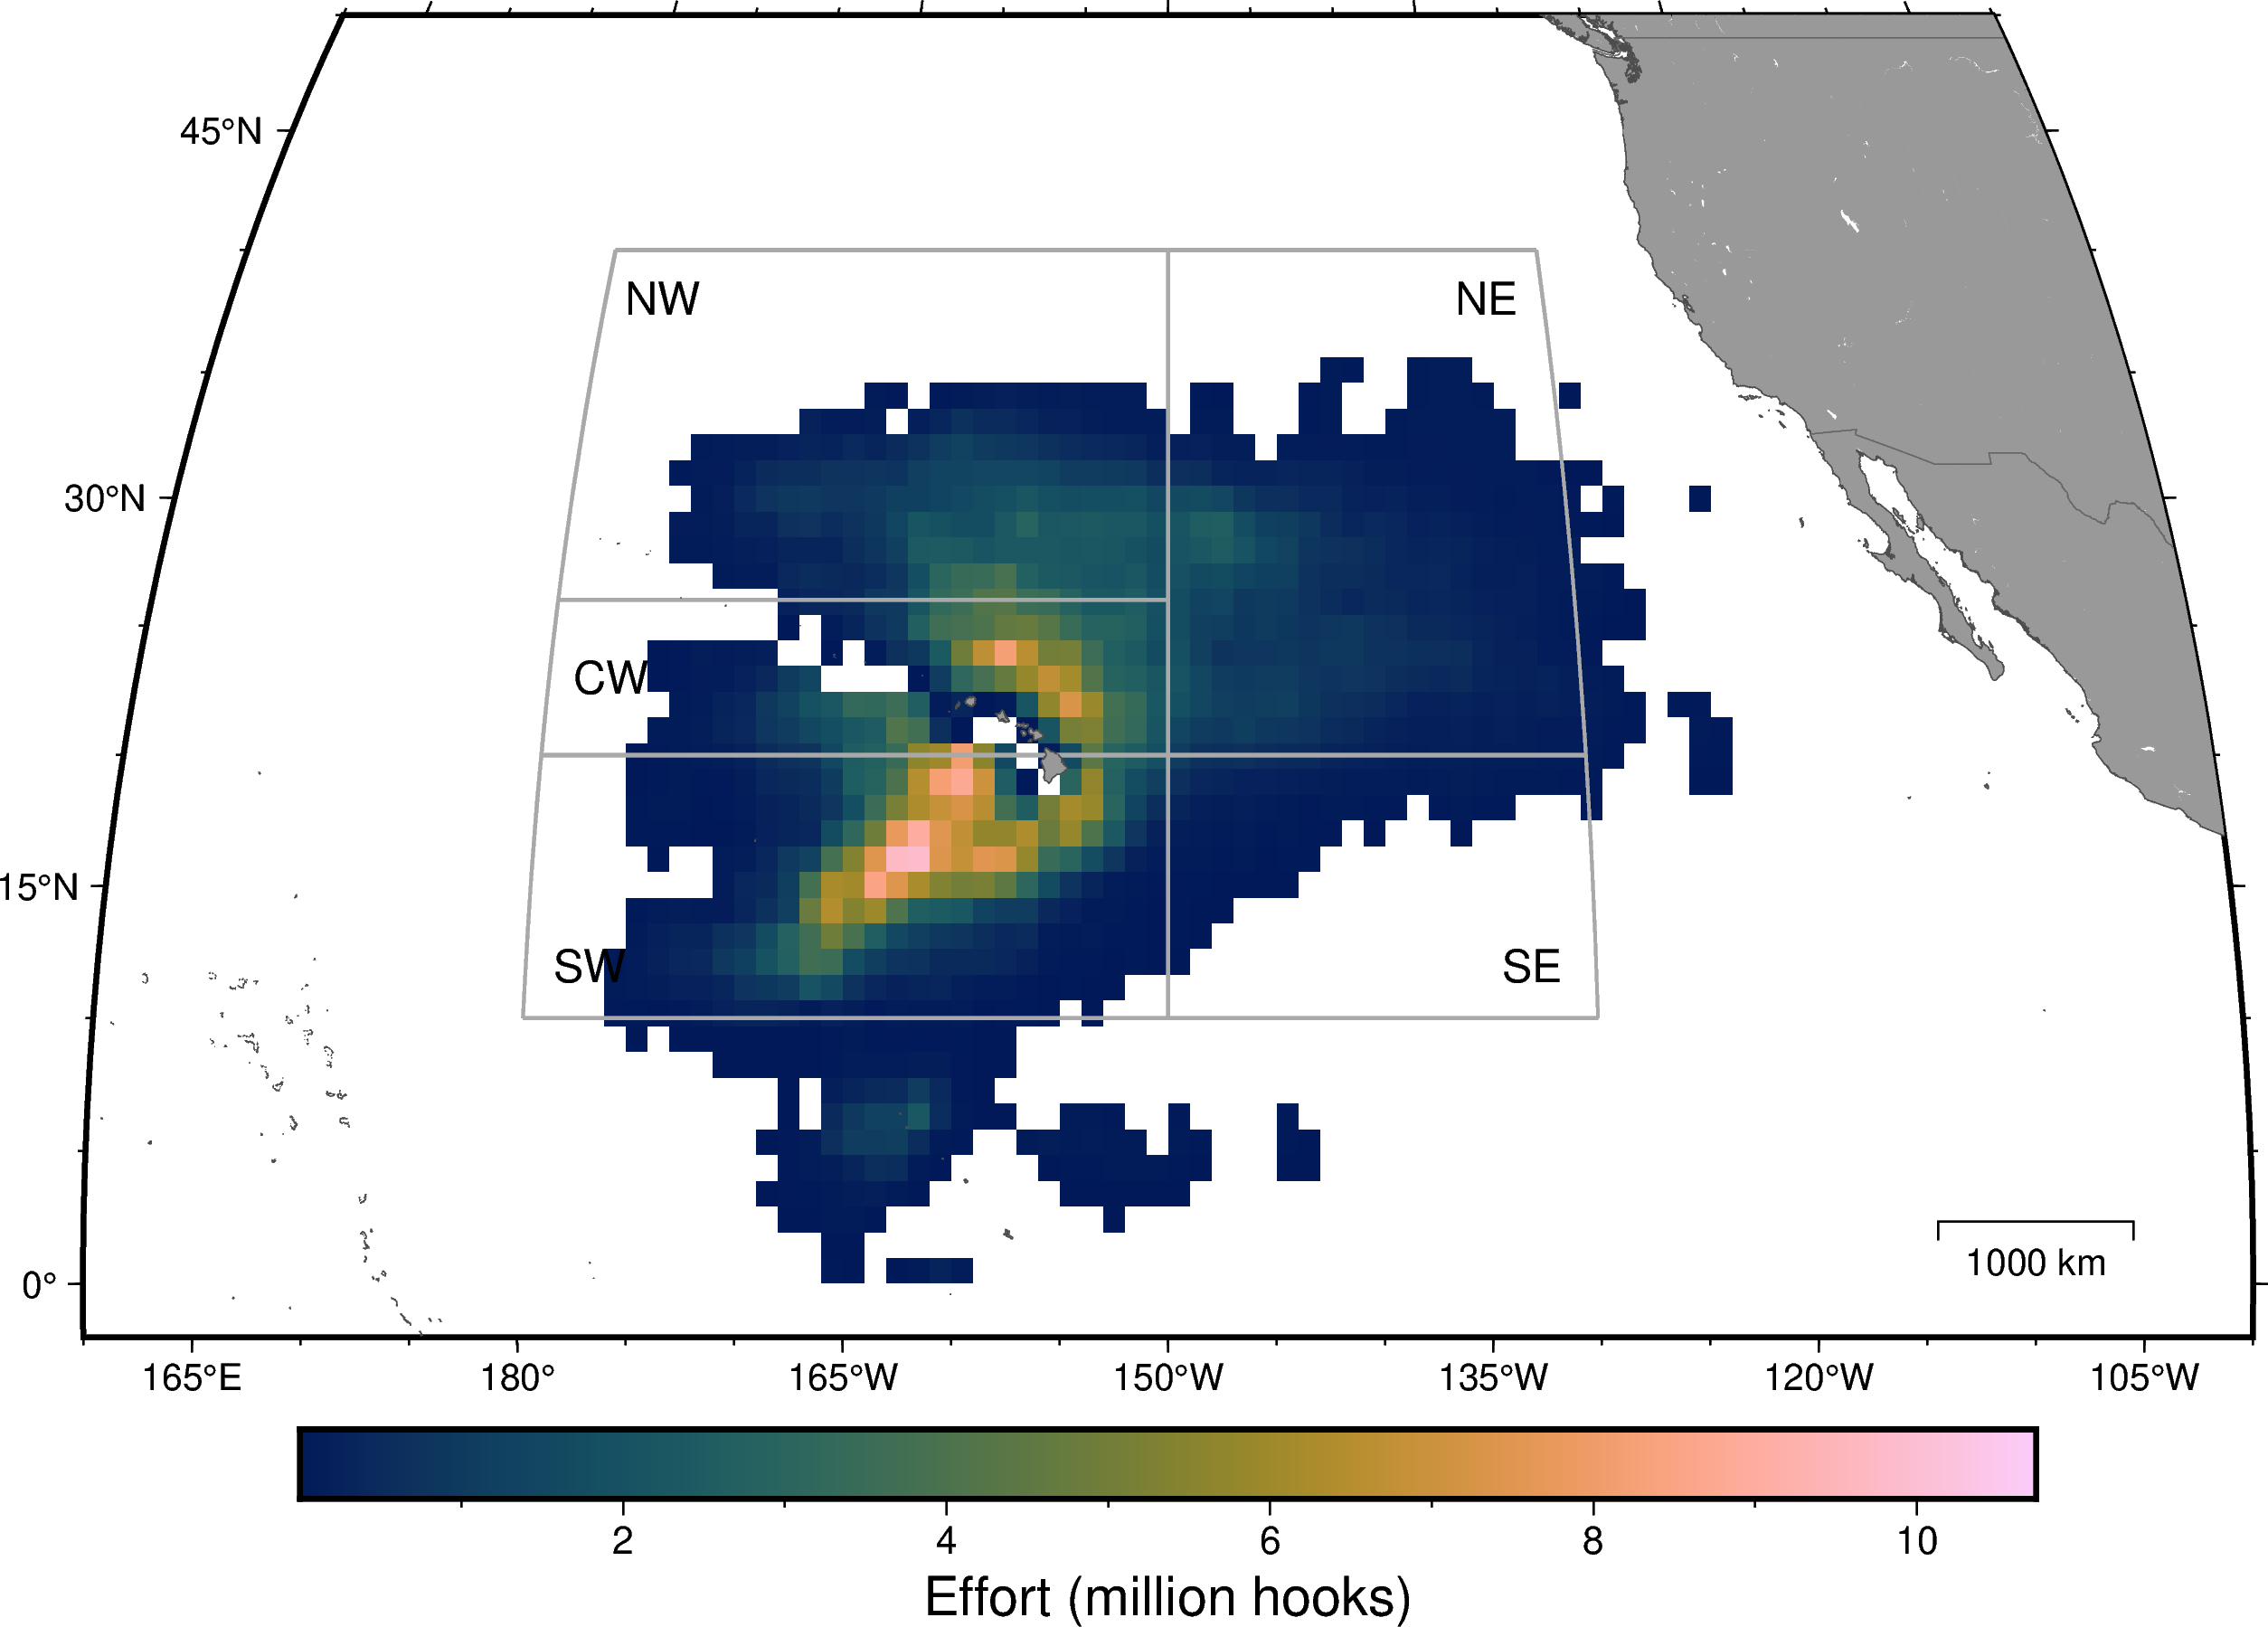

In [305]:
# Set region
region=[160, 260, -2, 50] # map region
projection='W8i' # N is Robinson projection. W is Mollwide, K is Eckert IV equal-area

# Initialize the figure
fig = pygmt.Figure()

# Set GMT defaults for this plot only
with pygmt.config(MAP_FRAME_TYPE="plain"):
# Make the basemap
    fig.basemap(region=region, 
                projection=projection,
                frame=["WSne", "af"], #frame='a', 
                map_scale="g-110/2+w1000k")  # Add scale bar

# Add Longline fishery
fig.grdimage(
    grid=effort, 
    projection=projection,
    region=region,
    cmap="batlow"
)
# Adds the main effort shape
'''fig.plot(
    projection=projection,
    region=region, 
    data=effort, 
    pen='1p,gray',
    fill='lightgray',
    label='Longline region'
)'''
# Add our study area horizontal lines
fig.plot(
    projection=projection,
    data=np.array([[180,40,-130,40],[180,26,-150,26],[180,20,-130,20],[180,10,-130,10]]),
    style="v0.4c+s",  # cartesian so the line is straight
    pen="1p,darkgray",
    label='Study region'
)
# Add our study area vertical lines
fig.plot(
    projection=projection,
    data=np.array([[180,40,180,10],[-150,40,-150,10],[-130,40,-130,10]]),
    style="=0.4c+s",  # geographic so there is a bowing to the line
    pen="1p,darkgray",
)
# Add the text
fig.text(
    projection=projection,
    text=['NW', 'CW', 'SW', 'NE', 'SE'],
    x=[-177, -177, -177, -133, -133],
    y=[38, 23, 12, 38, 12],
    font='12p,Helvetica,black'
)

# Add a coastline for a crisper look
fig.coast(projection=projection,
          resolution='h', 
          shorelines='1/0.25p,gray30', 
          borders=["1/0.25p,gray40"],
          land='gray60')

# Add a legend to the bottom right corner
#fig.legend(position="g-120/4", 
#           S=1.2)
# Add a colorbar
fig.colorbar(frame="x+lEffort (million hooks)")

# Display figure
fig.show()

# Save the figure
fig.savefig('/Users/jwren/Documents/ClimateVariability/ENSO_LonglineFishery/PubMap_Wollweide_effort_allPython.png', crop=True)


#### Making a shaded polygon for the majority of the effort

I'm making a polygon that encompasses all the points using a convex hull. Then plotting that polygon as the extent of the fishery.

In [ ]:
'''# Read in the csv with all catch data and remove some of the outliers for a cleaner look
df = pd.read_csv('~/Documents/ClimateVariability/ENSO_LonglineFishery/FisheryData/Longline data/DeepSets.csv')
df.BH_LON = df.BH_LON*-1
df = df.drop(df[df.BH_LAT>40].index) # remove some northern outliers
df = df.drop(df[df.BH_LON==0].index) # Remove the zero lon locations
mask1 = ~((df['BH_LAT'] < 1) & (df['BH_LON'] < -175)) # remove outlier to the southwest
mask2 = ~((df['BH_LAT'] < 15) & (df['BH_LON'] > -120))  # remove outlier to the southeast
mask3 = ~((df['BH_LAT'] < 10) & (df['BH_LON'] > -157))  # remove the southern blob of effort
mask4 = ~((df['BH_LAT'] < 15) & (df['BH_LON'] > -147))  # remove the southern blob of effort
mask = mask2 & mask1 & mask3 & mask4
df_filtered = df[mask]
df_filtered = df_filtered[df_filtered['HOOKSSET'] > 3000]

# Make points from the df
points = np.column_stack([df_filtered.BH_LON, df_filtered.BH_LAT])

# Make the concave hull
hull = concave_hull(points, length_threshold=5)
#plt.plot(hull2[:,0], hull2[:,1], '-r')
# turn it into a geopandas geometry
hullPoly = gpd.GeoDataFrame(geometry=[Polygon(hull)], crs='EPSG:4326')

# Smooth
smoothed = smoothify(
    geom=hullPoly,
    smooth_iterations=3,
    preserve_area=True,
    segment_length=2,
    num_cores=0,
)
# plot original and smoothed version
hullPoly.plot()
smoothed.plot()'''


### Below is an attempt at making the confidentiality mask but I'm having some issues with it, so I just did it in R becuase I know how to there. But I'm saving this code here for posterity for now. 

In [ ]:
'''import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from shapely.geometry import Point
from collections import defaultdict
import numpy as np

# 1. Load your DataFrame with lon, lat, and PERMITNUM columns
df = pd.read_csv('~/Documents/ClimateVariability/ENSO_LonglineFishery/FisheryData/Longline data/DeepSets.csv')
df.BH_LON = df.BH_LON*-1
df = df.drop(df[df.BH_LON==0].index) # Remove the zero lon locations
df'''

In [ ]:
'''# 2. Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(df['BH_LON'], df['BH_LAT'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# 3. Define raster template
bounds = gdf.total_bounds
pixel_size = 1  # in degrees, change as needed
width = int(np.ceil((bounds[2] - bounds[0]) / pixel_size))
height = int(np.ceil((bounds[3] - bounds[1]) / pixel_size))
transform = from_origin(bounds[0], bounds[3], pixel_size, pixel_size)
# define lon and lat for axes
lon = list(range(int(np.floor(bounds[0])), int(np.ceil(bounds[2])), pixel_size))
lat = list(range(int(np.floor(bounds[3])), int(np.ceil(bounds[1])),-pixel_size)) # had to flip this to go from N to S

# 4. Map points to raster cells and collect unique PERMITNUM values
pixel_values = defaultdict(set)

for idx, row in gdf.iterrows():
    # Convert point coordinates to raster cell indices
    col, row_idx = ~transform * (row.geometry.x, row.geometry.y)
    col, row_idx = int(col), int(row_idx)
    
    # Check if point is within raster bounds
    if 0 <= row_idx < height and 0 <= col < width:
        pixel_values[(row_idx, col)].add(row['PERMITNUM'])

# 5. Create raster array with unique counts
unique_counts = np.zeros((height, width), dtype='uint32')
for (row_idx, col), permits in pixel_values.items():
    unique_counts[row_idx, col] = len(permits)

print(len(lon), len(lat))
print(unique_counts.shape)

# replace anything lower than 3 with NAs and everything >= 3 with 1s as save as a xarray
mask = unique_counts.astype(float)
mask[mask < 3] = np.nan
mask[mask > 0] = 1
coords= {
    'latitude': lat,
    'longitude':lon
}
permnum = xr.DataArray(mask,coords)
dat = xr.DataArray(unique_counts, coords) 
permnum.plot()'''

In [ ]:
'''combo = dat * permnum
fig, axs = plt.subplots(ncols=3)
print(axs)
dat.plot(ax=axs[0])
permnum.plot(ax=axs[1])
combo.plot(ax=axs[2])'''
